# Neal's Funnel Target Practice

In [1]:
] activate "../"

  Activating project at `~/PhD/MyHMC/examples`


In [2]:
# The statistical inference frame-work we will use
using Turing
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MyHMC

In [3]:
d = 21
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

@model function true_funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), I)
    zz = z .* exp(θ/2)
    x ~ MvNormal(zz, I)
    
end

true_funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Random.seed!(1)
(;x) = rand(true_funnel() | (θ=0,))
true_model = true_funnel() | (;x)

DynamicPPL.Model{typeof(true_funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DynamicPPL.DefaultContext}}(true_funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [1.2142074831535152, 1.23371919965455, -0.8480146960461767, 0.1600994648479841, 1.9180385508479283, -3.401523464506408, -0.0957684186471088, 0.6734622629464286, -3.2749467689509633, -1.6760091758453226, 1.9567202902549736, 0.1136169088905351, 0.11117896909388916, -0.5373922347882832, -0.12436857036298687, -1.2901071061088532, 1.702584517514787, -0.44460133117954226, 1.0818722439221686, 1.2208011493237483],), DynamicPPL.DefaultContext()))

## MyHMC

In [8]:
spl = MyHMC.HMC(20, 0.25)
espl = externalsampler(spl)

Turing.Inference.ExternalSampler{MyHMC.MyHMCSampler}(MyHMC.MyHMCSampler(Settings(1, "LF"), MyHMC.Hyperparameters(0.25, 20, [0.0]), MyHMC.Leapfrog))

In [9]:
samples = sample(funnel_model, espl, 100_000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35


In [10]:
theta_mchmc = [samples.value.data[i, 1, :][1] for i in axes(samples.value.data)[1]]
x10_mchmc = [samples.value.data[i, 10+1, :][1] for i in axes(samples.value.data)[1]];

## NUTS

In [11]:
samples_hmc = sample(funnel_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.8
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:43


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 47.56 seconds
Compute duration  = 47.56 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

           θ   -0.0497    0.8655    0.0254    3042.0652    1209.4119    1.0003 ⋯
        z[1]    0.6036    0.7372    0.0040   33619.6032   31402.0978    1.0001 ⋯
        z[2]    0.6130    0.7369    0.0044   28609.9766   34566.2552    1.0000 ⋯
        z[3]   -0.4

In [12]:
truth_hmc = sample(true_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 37.85 seconds
Compute duration  = 37.85 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

           θ   -0.0794    0.9006    0.0092   14111.5975   11935.7938    1.0000 ⋯
        z[1]    0.5670    0.7163    0.0031   53549.9324   33890.4173    1.0000 ⋯
        z[2]    0.5779    0.7195    0.0031   54638.1935   34212.6707    1.0000 ⋯
        z[3]   -0.3

In [13]:
theta_hmc = [samples_hmc.value.data[i, 1, :][1] for i in axes(samples_hmc.value.data)[1]]
x10_hmc = [samples_hmc.value.data[i, 10+1, :][1] for i in axes(samples_hmc.value.data)[1]];


In [14]:
true_theta_hmc = [truth_hmc.value.data[i, 1, :][1] for i in axes(truth_hmc.value.data)[1]]
true_x10_hmc = [truth_hmc.value.data[i, 10+1, :][1] * exp(truth_hmc.value.data[i, 1, :][1]/2) for i in axes(truth_hmc.value.data)[1]];


## Comp

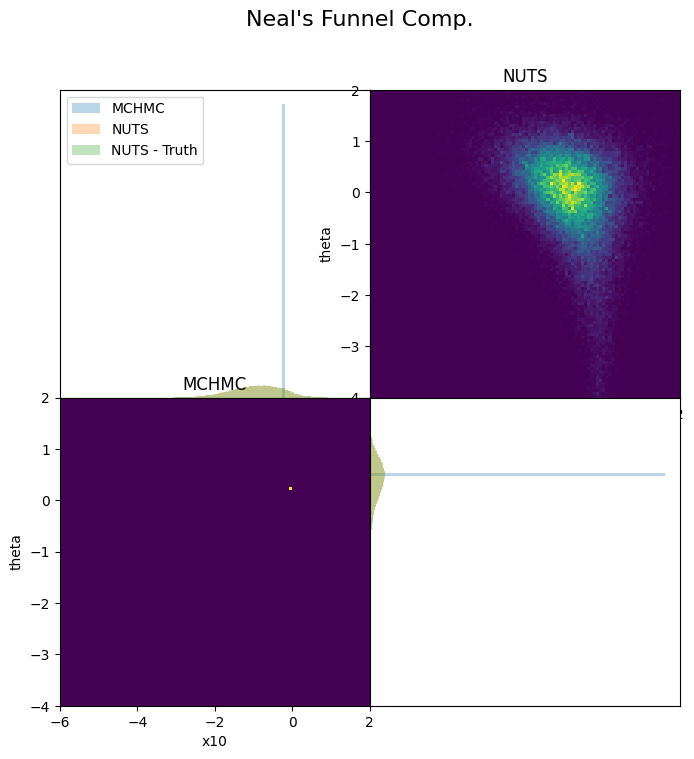

PyObject Text(0.5, 1.0, 'MCHMC')

In [18]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel Comp.", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="MCHMC")
axis[1,1].hist(x10_hmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="NUTS")
axis[1,1].hist(true_x10_hmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="NUTS - Truth")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, density=true, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(theta_hmc, bins=100, density=true, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100, density=true, orientation="horizontal", range=[-6,2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("NUTS")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("MCHMC")